## An end-to-end example: fine-tuning an image classification model on a cats vs. dogs dataset 
To solidify these concepts, let's walk you through a concrete end-to-end transfer learning & fine-tuning example. We will load the Xception model, pre-trained on ImageNet, and use it on the Kaggle "cats vs. dogs" classification dataset

In [1]:
# Necessary imports
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [2]:
# Get the data

"""Transfer learning is most useful when working with very small datasets. To keep our dataset small,
 we will use 40% of the original training data (25,000 images) for training, 10% for validation, and 10% for testing"""

import tensorflow_datasets as tfds

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteI1UGM9/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


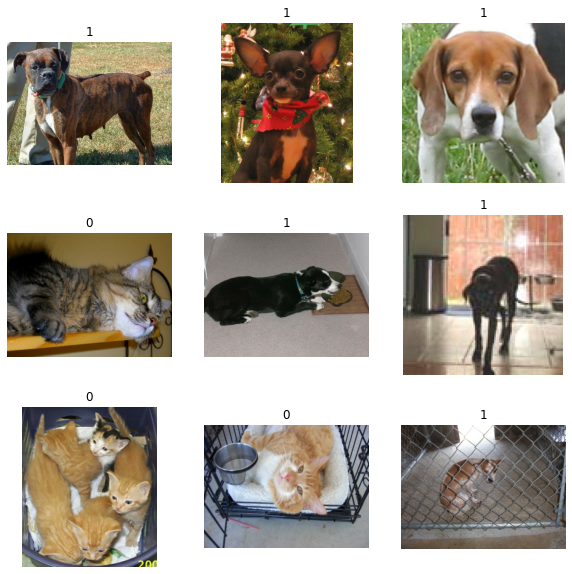

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

These are the first 9 images in the training dataset -- as you can see, they are all different sizes. We can also see that label 1 is "dog" and label 0 is "cat".

## Standardizing the data
Our raw images have a variety of sizes. In addition, each pixel consists of 3 integer values between 0 and 255 (RGB level values). This isn't a great fit for
feeding a neural network. Wee need to do 2 things:



* Standardize to a fixed image size. We pick (150, 150).
* Normalize pixel values between -1 and 1. We'll do this using a __Normalization__ lauer as part of the model itself.


In general, it's a good practice to develop models that take raw data as input, as opposed to models that take already-preprocessed data. The reason being that, if your model expects preprocessed data, any time you export your model to use it elsewhere (in a web browser, in a mobile app), you'll need to reimplement the exact same preprocessing pipeline. This gets very tricky very quickly. So we should do the least possible amount of preprocessing before hitting the model.

In [4]:
# Let's resize images to 150 * 150.
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [5]:
# Additionally, let's batch the data and use caching & prefetching to optimize loading speed.
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

## Using random data augmentation
When you don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This helps expose the model to different aspects of the training data while slowing down overfitting.

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

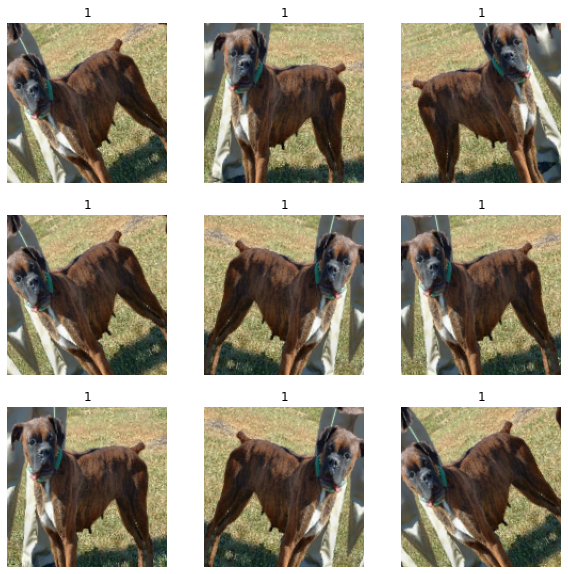

In [7]:
# Let's visualize what the first image of the first batch looks like after various random transformations:

import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:


* We add a Rescaling layer to scale input values (initially in the [0,255] range) to the [-1,1] range.
* We add a Dropout layer before the classification layer, for regularization.
* We make sure to pass training=False when calling the base model, so that it runs in inference mode, so that batchnorm statistics don't get updated even after we unfreeze the base model for fine-tuning.



In [8]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top. 

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

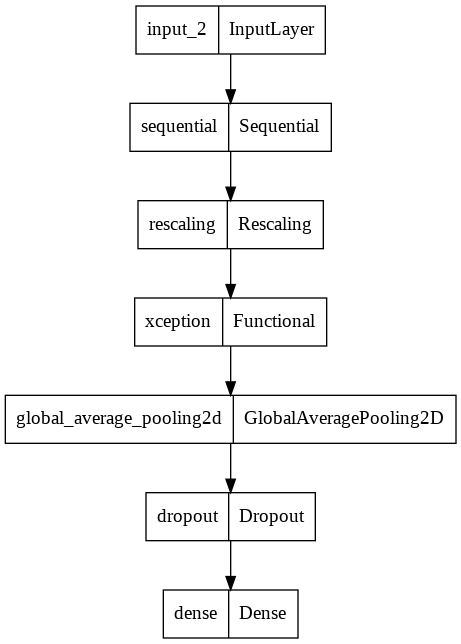

In [9]:
# Visualize the model
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False
)

## Train the top layer

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 40s 86ms/step - loss: 0.1678 - binary_accuracy: 0.9244 - val_loss: 0.0816 - val_binary_accuracy: 0.9708
Epoch 2/20
291/291 [==============================] - 23s 80ms/step - loss: 0.1214 - binary_accuracy: 0.9498 - val_loss: 0.0734 - val_binary_accuracy: 0.9729
Epoch 3/20
291/291 [==============================] - 25s 85ms/step - loss: 0.1112 - binary_accuracy: 0.9512 - val_loss: 0.0759 - val_binary_accuracy: 0.9708
Epoch 4/20
291/291 [==============================] - 24s 83ms/step - loss: 0.1065 - binary_accuracy: 0.9551 - val_loss: 0.0713 - val_binary_accuracy: 0.9733
Epoch 5/20
291/291 [==============================] - 23s 81ms/step - loss: 0.1032 - binary_accuracy: 0.9573 - val_loss: 0.0699 - val_binary_accuracy: 0.9733
Epoch 6/20
291/291 [==============================] - 24s 82ms/step - loss: 0.1012 - binary_accuracy: 0.9568 - val_loss: 0.0749 - val_binary_accuracy: 0.9703
Epoch 7/20
291/291 [==============================] 

In [11]:
model.evaluate(test_ds)

73/73 [==============================] - 6s 76ms/step - loss: 0.0773 - binary_accuracy: 0.9686


[0.0773225948214531, 0.9686156511306763]

## Do a round of fine-tuning of the entire model
Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.


In [12]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/10
291/291 [==============================] - 100s 317ms/step - loss: 0.0793 - binary_accuracy: 0.9674 - val_loss: 0.0560 - val_binary_accuracy: 0.9768
Epoch 2/10
291/291 [==============================] - 90s 309ms/step - loss: 0.0565 - binary_accuracy: 0.9793 - val_loss: 0.0438 - val_binary_accuracy: 0.9832
Epoch 3/10
291/291 [==============================] - 90s 308ms/step - loss: 0.0420 - binary_accuracy: 0.9837 - val_loss: 0.0449 - val_binary_accuracy: 0.9807
Epoch 4/10
291/291 [==============================] - 90s 308ms/step - loss: 0.0402 - binary_accuracy: 0.9838 - val_loss: 0.0521 - val_binary_accuracy: 0.9807
Epoch 5/10
291/291 [==============================] - 89s 307ms/step - loss: 0.0321 - binary_accuracy: 0.9859 - val_loss: 0.0467 - val_binary_accuracy: 0.9828
Epoch 6/10
291/291 [==============================] - 89s 307ms/step - loss: 0.0222 - binary_accuracy: 0.9922 - val_loss: 0.0532 - val_binary_accuracy: 0.9802
Epoch 7/10
291/291 [=========================

In [13]:
model.evaluate(test_ds)

73/73 [==============================] - 5s 62ms/step - loss: 0.0770 - binary_accuracy: 0.9759


[0.07701979577541351, 0.9759243130683899]

After 10 epochs, fine-tuning gains us a nice improvement here. This is an optional last step that can potentially give you incremental improvements. It could also potentially lead to quick overfitting -- keep that in mind